# 头盔设计
假设头盔编号区域的比例是4:3，
则长宽比为1.33

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageEnhance
from PIL import Image

In [2]:
path='test4.jpg'

In [3]:
gaussian_kernel = (3,3)

#对于大部分例子（10,1）最好
close_kernelX = (11,1)

erode_kernelY = (1,15)

# 读取

<class 'numpy.ndarray'>


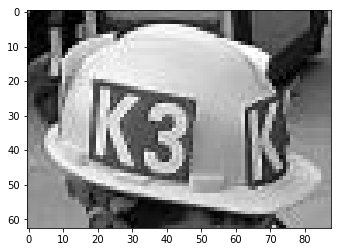

In [4]:
raw_img = cv2.imread(path)
raw_img = raw_img[:,:,[2,1,0]]
plt.imshow(raw_img)
print(type(raw_img))

<class 'numpy.ndarray'>


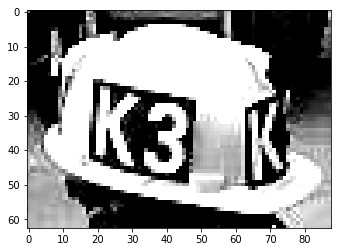

In [5]:
# 对比度增强
image_copy = Image.open(path)
enh_con = ImageEnhance.Contrast(image_copy)
contrast = 3
image_contrasted = enh_con.enhance(contrast)
image_contrasted = np.array(image_contrasted)
plt.imshow(image_contrasted)
print(type(image_contrasted))

# 灰度化

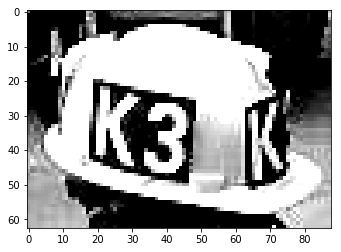

In [6]:
#gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
gray_img = cv2.cvtColor(image_contrasted, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img,'gray')

# 高斯模糊

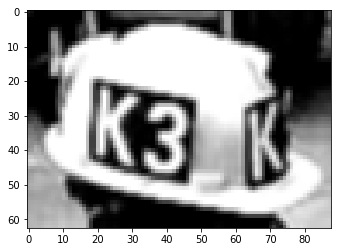

In [7]:
blurred = cv2.GaussianBlur(gray_img, gaussian_kernel, 0)
plt.imshow(blurred,'gray')

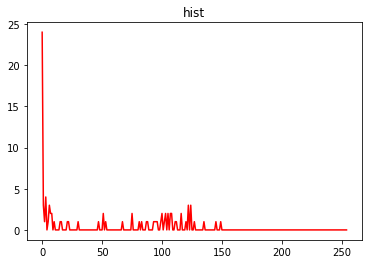

In [8]:
hist = cv2.calcHist(blurred,[0],None,[255],[0,255])
plt.plot(hist,'r')
plt.title('hist')
plt.show()

# Canny算子轮廓

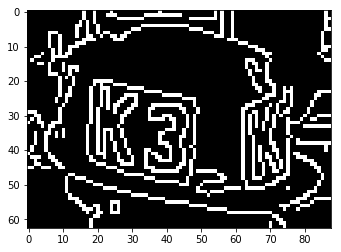

In [9]:
xgrad = cv2.Sobel(blurred, cv2.CV_16SC1, 1, 0)
ygrad = cv2.Sobel(blurred, cv2.CV_16SC1, 0, 1)
edge = cv2.Canny(xgrad, ygrad, 50, 150)
#cv.imshow("color边缘",edge_output)
plt.imshow(edge,'gray')

# sobel算子轮廓

<class 'numpy.ndarray'>


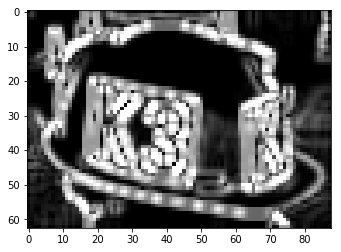

In [10]:
Sobel_x = cv2.Sobel(blurred, cv2.CV_16S, 1, 0)
Sobel_y = cv2.Sobel(blurred, cv2.CV_16S, 0, 1)
absX = cv2.convertScaleAbs(Sobel_x)  # 转回uint8
absY = cv2.convertScaleAbs(Sobel_y)
dst = cv2.addWeighted(absX, 0.6, absY, 0.4, 0)
plt.imshow(dst,'gray')
print(type(blurred))

# dst = cv2.Sobel(blurred,cv2.CV_16S,1,0)
# dst = cv2.convertScaleAbs(dst)
# plt.imshow(dst,'gray')
# print(type(blurred))

# 二值化

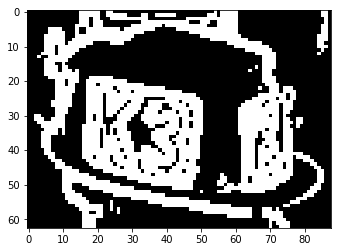

In [11]:
#canny算子
#ret, binary = cv2.threshold(edge, 0, 255, cv2.THRESH_OTSU)

#sobel算子
ret, binary = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU)
#ret, binary = cv2.threshold(dst,127,255,cv2.THRESH_BINARY)
plt.imshow(binary, 'gray')

# 闭运算 填充非联通区域（先膨胀再腐蚀）

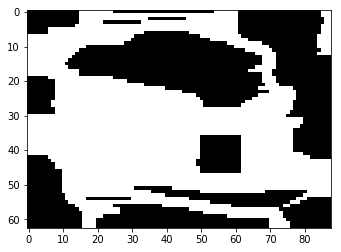

In [12]:
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, close_kernelX)
close_image = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernelX)
plt.imshow(close_image,'gray')

# 开运算 消除干扰 （先腐蚀后膨胀）

## x方向

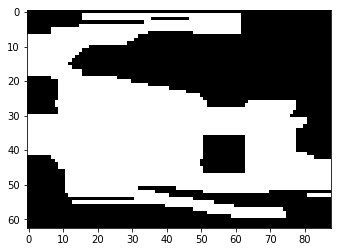

In [13]:
#定义核
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (14, 1))
kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, erode_kernelY)


#x方向先膨胀再腐蚀
image = cv2.erode(close_image, kernelX)
image = cv2.dilate(image, kernelX)

#image = cv2.erode(image, kernelX)

plt.imshow(image,'gray')


## y方向

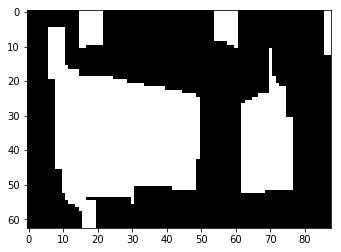

In [14]:
#y方向先膨胀再腐蚀
image = cv2.erode(close_image, kernelY)
image = cv2.dilate(image, kernelY)

#image = cv2.erode(image, kernelX)

plt.imshow(image,'gray')

# 去除竖的干扰

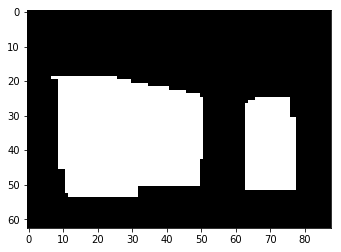

In [15]:
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (10,1))
final_img = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernelX)
plt.imshow(final_img,'gray')

## 对比原图

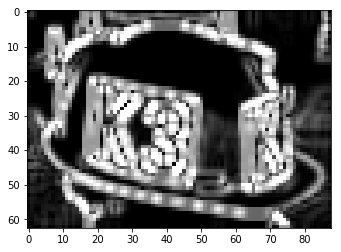

In [16]:
plt.imshow(dst,'gray')

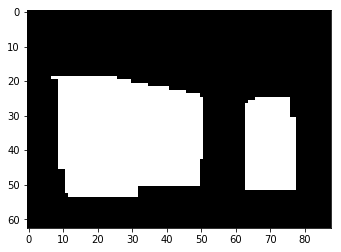

In [17]:
plt.imshow(final_img,'gray')

In [18]:
#定义显示函数
def show(name, img):
    cv2.namedWindow(name, 0)
    cv2.imshow(name, img)
    cv2.waitKey(0)

# 轮廓

In [19]:
# 查找轮廓
contours,hierarchy = cv2.findContours(final_img,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 读出轮廓个数
print('发现了' ,len(contours) ,'个轮廓')
print(type(contours))

#读出轮廓面积
for i,cnt in enumerate(contours):
    print('第',i+1 ,'个轮廓的面积是',cv2.contourArea(cnt))


发现了 2 个轮廓
<class 'list'>
第 1 个轮廓的面积是 349.5
第 2 个轮廓的面积是 1239.5


## 对轮廓进行筛选

### 面积筛选

In [20]:
# 预先筛选出面积
# 假设面积在150到2000之间
contours = [cnt for cnt in contours if (cv2.contourArea(cnt) > 150 and cv2.contourArea(cnt)< 2000)]  
print('面积筛选后的轮廓个数是',len(contours))

img_contour = cv2.drawContours(raw_img, contours, -1, (0, 0, 255), 2)

# 显示面积筛选的轮廓

# cv2.namedWindow('box_contours', 0)
# cv2.imshow('box_contours',img_contour)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

面积筛选后的轮廓个数是 2


### 长宽比值筛选

In [21]:
number_contours = []

#对长宽比进行筛选
for i, cnt in enumerate(contours):
    #遍历所有轮廓，求出轮廓的最小外接矩阵
    rect = cv2.minAreaRect(cnt)
    area_width, area_height = rect[1]
    #输出每个面积的长宽比
    print('第',i+1,'个轮廓的长，宽是:','长', round(area_width,3), ' 宽', round(area_height,3))

    if area_width < area_height:
        area_width, area_height = area_height, area_width
    wh_ratio = area_width / area_height
    print('第',i+1,'个轮廓的长宽比值为',round(wh_ratio,3))
    #要求矩形区域长宽比在2到5.5之间，2到5.5是车牌的长宽比，其余的矩形排除
    if wh_ratio >= 1 and wh_ratio < 2.5:
        number_contours.append(cnt)

#输出筛选结果  

print('---------------------------------------------------')        
print("长宽筛选后的轮廓个数为：", len(number_contours))

第 1 个轮廓的长，宽是: 长 14.0  宽 26.0
第 1 个轮廓的长宽比值为 1.857
第 2 个轮廓的长，宽是: 长 34.0  宽 43.0
第 2 个轮廓的长宽比值为 1.265
---------------------------------------------------
长宽筛选后的轮廓个数为： 2


# 生成最小外接矩阵

In [23]:
number_contours = sorted(number_contours, key=cv2.contourArea, reverse=True)
img_contour = cv2.drawContours(raw_img, number_contours, -1, (0, 0, 255), 2)
rect_final = cv2.minAreaRect(number_contours[0])
box = cv2.boxPoints(rect_final)
box = np.int0(box)
for i,item in enumerate(box):
    print('point' , i+1, ':', item)
    print(type(item))

raw_img = raw_img[:,:,[2,1,0]]
box_contours = cv2.drawContours(raw_img, [box], 0, (0, 0, 255), 1)


# x, y, w, h = cv2.boundingRect(number_contours[0])
# print(x,y,w,h)
# cv2.rectangle(raw_img, (x,y), (x+w,y+h), (153,153,0), 5) 
# newimage=raw_img[y+2:y+h-2,x+2:x+w-2] # 先用y确定高，再用x确定宽


# cv2.namedWindow('box_contours', 0)
# cv2.imshow('box_contours',box_contours)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(box)

point 1 : [50 53]
<class 'numpy.ndarray'>
point 2 : [ 7 53]
<class 'numpy.ndarray'>
point 3 : [ 7 19]
<class 'numpy.ndarray'>
point 4 : [50 19]
<class 'numpy.ndarray'>
[[50 53]
 [ 7 53]
 [ 7 19]
 [50 19]]
